# Summary

# Imports

In [1]:
import importlib
import sys
from pathlib import Path
from IPython.display import clear_output, display

import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
%matplotlib inline

pd.set_option("max_columns", 100)

In [3]:
%run spark.ipynb

In [4]:
SRC_PATH = Path.cwd().joinpath('..', 'src').resolve(strict=True)

if SRC_PATH.as_posix() not in sys.path:
    sys.path.insert(0, SRC_PATH.as_posix())

import helper
importlib.reload(helper)

<module 'helper' from '/gpfs/fs0/scratch/p/pmkim/strokach/datapkg/adjacency-net-v2/src/helper/__init__.py'>

# Parameters

In [5]:
NOTEBOOK_PATH = Path(os.getenv("CI_JOB_NAME", "add_adjacency_distances_test"))
NOTEBOOK_PATH

PosixPath('add_adjacency_distances_test')

In [6]:
OUTPUT_PATH = Path(os.getenv('OUTPUT_DIR', NOTEBOOK_PATH.name)).resolve()
OUTPUT_PATH.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH

PosixPath('/gpfs/fs0/scratch/p/pmkim/strokach/datapkg/adjacency-net-v2/notebooks/add_adjacency_distances_test')

In [7]:
DEBUG = "CI" not in os.environ    

TASK_ID = os.getenv("SLURM_ARRAY_TASK_ID")
TASK_COUNT = os.getenv("ORIGINAL_ARRAY_TASK_COUNT") or os.getenv("SLURM_ARRAY_TASK_COUNT")

TASK_ID = int(TASK_ID) if TASK_ID is not None else None
TASK_COUNT = int(TASK_COUNT) if TASK_COUNT is not None else None

TASK_ID, TASK_COUNT

(None, None)

In [8]:
DATASET_NAME = 'training_dataset'
DATASET_WDISTANCES_NAME = DATASET_NAME + '_wdistances'

In [9]:
if DEBUG:
    %load_ext autoreload
    %autoreload 2

# `DATAPKG`

In [10]:
DATAPKG = {
    # Training
    'training_dataset': 
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "adjacency-net-v2", "master", "training_dataset"),
    'training_dataset_wdistances':
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "adjacency-net-v2", "master", "training_dataset_wdistances"),
    # Validation
    'validation_dataset': 
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "adjacency-net-v2", "master", "validation_dataset"),
    'validation_dataset_wdistances':
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "adjacency-net-v2", "master", "validation_dataset_wdistances"),
    # Test
    'test_dataset': 
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "adjacency-net-v2", "master", "test_dataset"),
    'test_dataset_wdistances':
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "adjacency-net-v2", "master", "test_dataset_wdistances"),
    # Other
    'pdb_mmcif_ffindex':
        Path(os.environ['DATAPKG_OUTPUT_DIR']).joinpath(
            "pdb-ffindex", "master", "pdb_mmcif_ffindex", "pdb-mmcif"),
}

# Count rows globally

### Count number of rows in `{DATASET_NAME}`

In [11]:
sql_query = rf"""
select count(*)
from parquet.`{DATAPKG[DATASET_NAME]}/adjacency_matrix.parquet`
"""

print(sql_query)


select count(*)
from parquet.`/gpfs/fs0/scratch/p/pmkim/strokach/databin/adjacency-net-v2/master/training_dataset/adjacency_matrix.parquet`



In [12]:
ds = spark.sql(sql_query)

In [13]:
df = ds.toPandas()

In [14]:
df  # 47402360

,count(1)
0,47402360


### Count number of rows in `{DATASET_WDISTANCES_NAME}`

In [15]:
sql_query = rf"""
select count(*)
from parquet.`{DATAPKG[DATASET_WDISTANCES_NAME]}/adjacency_matrix.parquet`
"""

print(sql_query)


select count(*)
from parquet.`/gpfs/fs0/scratch/p/pmkim/strokach/databin/adjacency-net-v2/master/training_dataset_wdistances/adjacency_matrix.parquet`



In [16]:
ds_wdistances = spark.sql(sql_query)

In [17]:
df_wdistances = ds_wdistances.toPandas()

In [18]:
df_wdistances  # 34257954

,count(1)
0,34164433


In [19]:
df_wdistances.values.item() / df.values.item()

0.7207327441080993

### Print missing folders

In [20]:
missing_domains = []

for folder in DATAPKG[DATASET_NAME].joinpath("adjacency_matrix.parquet").glob("*"):
    folder_parts = list(folder.parts)
    assert folder_parts[-3] == DATASET_NAME
    folder_parts[-3] = DATASET_WDISTANCES_NAME
    folder_wdistances = Path(*folder_parts)
    if not folder_wdistances.exists():
        # Make sure the original folder has a Parquet file
        sql_query = f"select count(*) from parquet.`{next(folder.glob('*.parquet'))}`"
        df = spark.sql(sql_query).toPandas()
        count = df.values.item()
        missing_domains.append((folder_parts[-1], count))

missing_domains

[('database_id=G3DSA%3A3.40.50.1440', 62807),
 ('database_id=G3DSA%3A3.20.80.10', 43126),
 ('database_id=G3DSA%3A3.30.1050.10', 34935),
 ('database_id=G3DSA%3A3.30.110.60', 11123),
 ('database_id=G3DSA%3A1.10.10.440', 12939),
 ('database_id=G3DSA%3A1.10.10.41', 2895),
 ('database_id=G3DSA%3A3.30.1140.32', 17973),
 ('database_id=G3DSA%3A3.30.1120.40', 3065),
 ('database_id=G3DSA%3A2.60.40.1200', 53),
 ('database_id=G3DSA%3A1.10.10.250', 18310),
 ('database_id=G3DSA%3A2.60.40.1090', 45878),
 ('database_id=G3DSA%3A3.50.7.10', 57672),
 ('database_id=G3DSA%3A3.50.70.10', 6224),
 ('database_id=G3DSA%3A1.10.10.10', 3400746),
 ('database_id=G3DSA%3A3.20.20.70', 1701341),
 ('database_id=G3DSA%3A1.25.40.10', 2105462),
 ('database_id=G3DSA%3A3.20.90.10', 5021),
 ('database_id=G3DSA%3A3.40.640.10', 940256),
 ('database_id=G3DSA%3A1.10.10.190', 11),
 ('database_id=G3DSA%3A1.10.10.410', 28270),
 ('database_id=G3DSA%3A1.10.10.180', 1311),
 ('database_id=G3DSA%3A3.30.1040.10', 11),
 ('database_id=G3DS

### Make sure there is exactly one parquet file per folder

In [21]:
import os
from os.path import join, getsize

for folder in DATAPKG[DATASET_NAME].joinpath("adjacency_matrix.parquet").glob("*"):
    parquet_files = list(folder.glob("*.parquet"))
    if len(parquet_files) != 1:
        print(folder)
        print(parquet_files)
        print()

### Make sure we did not create any additional folders

In [22]:
folder_set_1 = set([
    p.parent.name
    for p in
    DATAPKG[DATASET_NAME].joinpath("adjacency_matrix.parquet").glob("*/*.parquet")
])

In [23]:
folder_set_2 = set([
    p.parent.name
    for p in
    DATAPKG[DATASET_WDISTANCES_NAME].joinpath("adjacency_matrix.parquet").glob("*/*.parquet")
])

In [24]:
assert (folder_set_1 - folder_set_2) == (folder_set_1 ^ folder_set_2)

### Make sure we did not create any additional files

In [25]:
file_set_1 = set([
    p.name
    for p in
    DATAPKG[DATASET_NAME].joinpath("adjacency_matrix.parquet").glob("*/*.parquet")
])

In [26]:
file_set_2 = set([
    p.name
    for p in
    DATAPKG[DATASET_WDISTANCES_NAME].joinpath("adjacency_matrix.parquet").glob("*/*.parquet")
])

In [27]:
assert (file_set_1 - file_set_2) == (file_set_1 ^ file_set_2)

## Count rows by domain

### Create a dataframe containing number of rows before and after

In [28]:
parquet_files_wdistances = list(
    DATAPKG[DATASET_WDISTANCES_NAME].joinpath("adjacency_matrix.parquet").glob("*/*.parquet")
)

sql_query_template = """
select count(*)
from parquet.`{file}`
"""

data = []
for i, file_wdistances in enumerate(parquet_files_wdistances):
    if i % 10 == 0:
        clear_output(wait=True)
        display(f"{i / len(parquet_files_wdistances):.2%}")
    path_parts = list(file_wdistances.parts)
    path_parts[-4] = DATASET_NAME
    file = Path(*path_parts)

    df1 = spark.sql(sql_query_template.format(file=file)).toPandas()
    df2 = spark.sql(sql_query_template.format(file=file_wdistances)).toPandas()
    
    count1 = df1.values.item()
    count2 = df2.values.item()

    data.append((file, count1, count2))

'99.30%'

In [29]:
row_counts_df = pd.DataFrame(
    data, columns=["filepath", "count", "count_wdistances"],
)
row_counts_df["filename"] = [
    p.name for p in row_counts_df["filepath"]
]
row_counts_df["dirname"] = [
    p.parent.name for p in row_counts_df["filepath"]
]
row_counts_df["filepath"] = row_counts_df["filepath"].apply(lambda p: p.as_posix())

row_counts_df.head()

,filepath,count,count_wdistances,filename,dirname
0,/gpfs/fs0/scratch/p/pmkim/strokach/databin/adj...,54,53,part-00000-2ae3a02a-2611-4bda-ac19-41025a3a6e7...,database_id=G3DSA%3A3.40.1000.20
1,/gpfs/fs0/scratch/p/pmkim/strokach/databin/adj...,28058,28051,part-00000-eea29c72-b7db-4c8b-807e-c187f1d1488...,database_id=G3DSA%3A3.30.1330.90
2,/gpfs/fs0/scratch/p/pmkim/strokach/databin/adj...,4538,4524,part-00000-11be5e6c-a2b9-4dab-b163-65c195fa083...,database_id=G3DSA%3A3.90.1420.10
3,/gpfs/fs0/scratch/p/pmkim/strokach/databin/adj...,2582,2582,part-00000-d147c9a8-08a6-4b6a-b6f2-55b5926a501...,database_id=G3DSA%3A2.60.40.350
4,/gpfs/fs0/scratch/p/pmkim/strokach/databin/adj...,3548,3546,part-00000-fc143921-ddbc-487a-9f77-0dc98ccd786...,database_id=G3DSA%3A1.10.1240.20


### Make sure we did not gain any rows

In [30]:
assert row_counts_df[
    (row_counts_df["count"] < row_counts_df["count_wdistances"])
].empty

### Print the fraction of rows that we lost

Text(0, 0.5, 'Number of Gene3D domains')

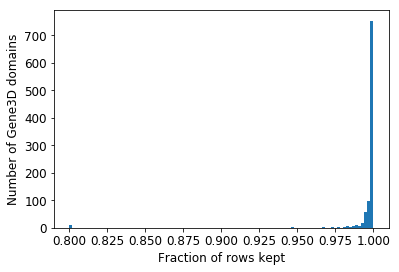

In [31]:
frac_kept = row_counts_df["count_wdistances"].values / row_counts_df["count"].values
# frac_kept = frac_kept[frac_kept < 1]

with plt.rc_context(rc={"font.size": 12}):
    plt.hist(np.clip(frac_kept, 0.8, 1), bins=100)
    
plt.xlabel("Fraction of rows kept")
plt.ylabel("Number of Gene3D domains")